In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math

%matplotlib notebook

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [18]:
p = Project.objects.get(pk=127)

docs = Doc.objects.filter(docproject__project=p, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query__project=p, 
    relevant__gt=0
).values_list('doc__pk', flat=True))

seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

8553


235

In [19]:
seen_docs.filter(
    docproject__project=p
).values('docproject__relevant').annotate(
    n = Count('pk')
)

<QuerySet [{'docproject__relevant': 1, 'n': 135}, {'docproject__relevant': 2, 'n': 100}]>

In [20]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(8318, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,1713,We compared the greenhouse gas (GHG) emissions...,Reductions in greenhouse gas emissions by usin...,Soil liquefaction; Greenhouse gas balance; Log...,"[Forestry; Materials Science, Paper & Wood]",0,0
1,3387,"During recent years, extensive studies have be...","High-pressure adsorption of methane, carbon di...",gas adsorption; methane; carbon dioxide; prefe...,[Geochemistry & Geophysics],0,0
2,5467,Underground coal mines worldwide Liberate an e...,Status of worldwide coal mine methane emission...,coalbed methane; global warming; coal mining; ...,"[Energy & Fuels; Geosciences, Multidisciplinary]",0,0
3,5771,In this study we analyze the primary energy an...,Primary energy and greenhouse gas implications...,Greenhouse gas; Forest management; Fertilizati...,[Agricultural Engineering; Biotechnology & App...,0,0
4,5976,Wind offers an important alternative to coal a...,Potential for Wind-Generated Electricity in China,None,[Multidisciplinary Sciences],0,0


In [21]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])
    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(235, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,18307,The poorest countries have a strong interest i...,Curbing carbon without curbing development,None,None,1,1
1,57222,In this paper we propose a market mechanism fo...,Brown coal exit: A market mechanism for regula...,None,None,1,1
2,69411,The closure of coal mines does not terminate t...,Closed coal mine shaft as a source of carbon d...,Carbon dioxide emissions; Coal mine closure; G...,"[Environmental Sciences; Geosciences, Multidis...",1,1
3,109398,A range of major risks associated with a rapid...,Risk assessment of UK electricity supply in a ...,energy transitions; UK electricity generation;...,"[Thermodynamics; Engineering, Mechanical]",0,1
4,138780,Four policies might close the gap between the ...,GDP and employment effects of policies to clos...,employment; abatement strategies; climate chan...,[Environmental Studies; Public Administration],1,1


In [22]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,1986578,The paper deals with the experimental study of...,Process of solid particle concentration enrich...,None,None,0,0
1,909013,"Regulatory changes in the EU and Germany, and ...",Ash and slag properties for co-gasification of...,Sewage sludge; Coal; Co-gasification; Entraine...,"[Chemistry, Applied; Energy & Fuels; Engineeri...",0,0
2,917587,The pulverizing system serves an important fun...,Modelling and control of pulverizing system co...,Dynamic model; Coal moisture; Pulverized coal ...,[Thermodynamics; Energy & Fuels],0,0
3,986206,The pore structure and gas adsorption property...,Experimental Research on Pore Structure and Ga...,deformed coal; pore structure; nitrogen adsorp...,"[Energy & Fuels; Engineering, Chemical; Engine...",0,0
4,975175,The paper presents the results of laboratory-s...,LABORATORY TESTS OF HYDROGEN PRODUCTION THROUG...,Coal; hydrogen production; gasification; CO(2)...,[Environmental Sciences],0,0


In [23]:
duplicateRowsDF = df[df.duplicated(['id'])]
duplicateRowsDF.shape

(0, 7)

In [24]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
#pred_index = pd.Index(random.sample(list(unseen_index),5000))

k = math.ceil(len(seen_index)*0.8)
train_index = pd.Index(random.sample(list(seen_index),k))

print(seen_index)
print(train_index)

#experiment_index = pd.Index(set(seen_index) | set(pred_index))

test_index = pd.Index([x for x in seen_index if x not in train_index])


Int64Index([  15,   27,  168,  171,  178,  196,  242,  245,  248,  284,
            ...
            8171, 8208, 8217, 8233, 8280, 8349, 8357, 8423, 8448, 8529],
           dtype='int64', length=235)
Int64Index([ 767, 1070, 2151, 4355, 1030, 4986, 5542, 2256, 1187, 1201,
            ...
            3548, 6050, 3686, 1901, 1928, 4897, 2215, 6243, 2534, 5808],
           dtype='int64', length=188)


In [25]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5, max_df=0.6, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

y = df['relevant']
ab_X = vec.fit_transform(df['content'])

<IPython.core.display.Javascript object>


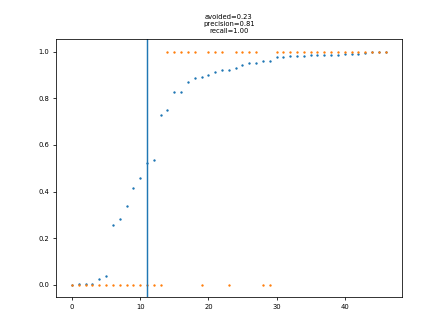

In [26]:
import importlib
importlib.reload(learning_utils)

clf = MultinomialNB(alpha=0.1)
clf.fit(ab_X[train_index],y[train_index])

fig, ax = plt.subplots()
learning_utils.plot_model_accuracy(clf,ab_X[test_index],y[test_index],ax,0.5)

In [27]:
model = {}
model['p'] = []
model['r'] = []
model['e'] = []
model['i'] = []

kf = KFold(n_splits=5)

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    clf = MultinomialNB(alpha=0.1)
    clf.fit(ab_X[k_train],y[k_train])
    predictions = clf.predict(ab_X[k_test])
    model['e'].append(clf.score(ab_X[k_test],y[k_test]))
    # Precision
    model['p'].append(precision_score(predictions,y[k_test]))
    # Recall
    model['r'].append(recall_score(predictions,y[k_test]))
    #print(k_train)
    

<IPython.core.display.Javascript object>


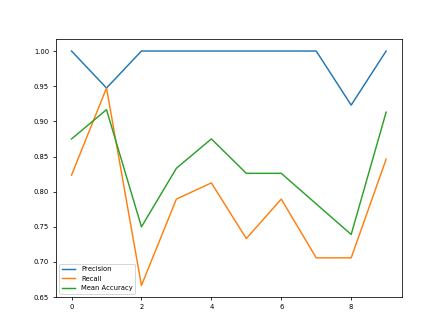

In [48]:
fig, ax = plt.subplots()
ax.plot(model['p'],label="Precision")
ax.plot(model['r'],label="Recall")
ax.plot(model['e'],label="Mean Accuracy")

plt.legend()

plt.show()

In [29]:
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    for model in models:
        clf = model['model']
        i+=1
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

<IPython.core.display.Javascript object>


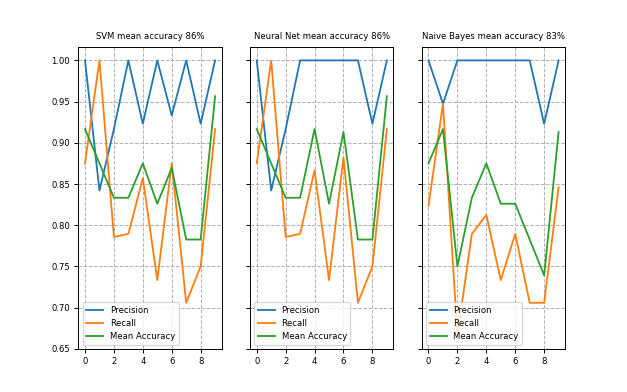

In [52]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.plot(model['p'],label="Precision")
    ax.plot(model['r'],label="Recall")
    ax.plot(model['e'],label="Mean Accuracy")
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

In [53]:
clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [54]:
df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]
for i, p in enumerate(y_pred[:,1]):
    ind = unseen_index[i]
    break
y_pred.shape

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(8318, 2)

<IPython.core.display.Javascript object>


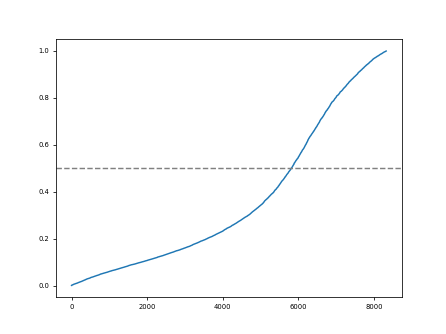

2505


In [61]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [62]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
q = Query.objects.get(pk=6311)
t1 = Tag(
    title="predicted relevant sample {}_1".format(now),
    query=q
)
t1.save()
t2 = Tag(
    title="predicted relevant sample {}_2".format(now),
    query=q
)
t2.save()

tag = t1

users = q.users.all()
uc = len(users)
for i, row in df.sort_values('prediction',ascending=False).head(1000).reset_index(drop=True).iterrows():
    if i > 499:
        tag = t2
    d = Doc.objects.get(id=row['id'])
    d.tag.add(tag)
    u = users[i % uc]
    do = DocOwnership(
        doc=d,
        user=u,
        query=q,
        tag=tag
    )
    do.save()
    
t1.update_tag()
t2.update_tag()

In [63]:
unseen_unallocated = df[df['seen']==0].sort_values('prediction',ascending=False).reset_index(drop=True)[1500:]
print(f"{unseen_unallocated.shape[0]} Docs are still unseen and unallocated")

6818 Docs are still unseen and unallocated


In [64]:
# Assign a random sample of unallocated docs

unseen_unallocated = unseen_unallocated.sample(500)

t3 = Tag(
    title="random unallocated sample {}".format(now),
    query=q
)
t3.save()
for i, row in unseen_unallocated.reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    d.tag.add(t3)
    u = users[i % uc]
    do = DocOwnership(
        doc=d,
        user=u,
        query=q,
        tag=t3
    )
    do.save()
    
t3.update_tag()

<IPython.core.display.Javascript object>


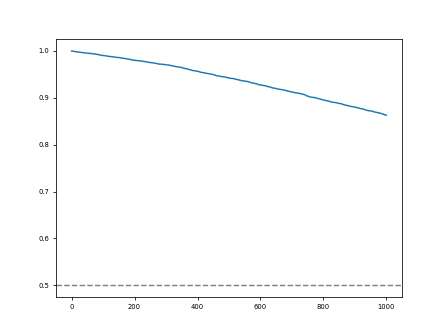

1000


In [66]:
pdf = df.sort_values('prediction',ascending=False).head(1000).reset_index(drop=True)
fig, ax = plt.subplots()
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [67]:
df.to_csv(f'doctables/predictions_{now}.csv',index=False)